In [ ]:
# %% 
"""
Note: I need to import the data from parameters.py
"""

import pyomo.environ as pyo
import importlib


import parameters
from parameters import *

from analysis import plot_solution, plot_solution_with_map, plot_solution_with_covering_radius, plot_solution_with_map_zoom, generate_facility_summary, display_selected_variables

# Change scenario dynamically
scenario_name = "terkidi_baseline"  # New scenario
parameters.scenario_name = scenario_name  # Update it in the session
importlib.reload(parameters)  # Reload the module to apply changes

# Display parameters for the new scenario
print(parameters.params)


{'location_file': 'individual_refugee_camps/terkidi_baseline.geojson', 'distance_matrix': 'individual_refugee_camps/distance_matrix_terkidi_baseline.xlsx', 'HFs_to_locate': [2, 1], 't1max': 1000, 't2max': 3500, 'workers_to_allocate': [1, 14, 14], 'total_population': 700, 'demand_rate_opening_hours': [0.01428571429, 0.00428571428, 0.00142857142], 'demand_rate_closing_hours': [0.00428571428, 0.00285714285, 0.00142857142], 'working_hours': [7, 8, 8], 'service_time': [0.5, 1, 2], 'lb_workers': [[0, 1], [1, 2], [1, 2]], 'ub_workers': [[1, 1], [14, 14], [14, 14]], 'services_at_HFs': [[1, 0], [1, 1], [0, 1]], 'services_per_worker': [[1, 0, 1], [1, 1, 0], [0, 1, 1]]}


In [4]:
def model_mshlam_mar25_CAMPS(obj, optimum_values, eps, model_data):
    """
    Inputs:
        model_data is a dictionary that contains the following elements: 
            I (array): (indices of) demand points; eg, ['i1','i2',...,'i16']
            J (array): (indices of) candidate locations for HFs; eg, ['j1',...,'j9']
            J_HP (array): (indices of) candidate locations for HPs; eg, ['j2','j3','j4','j6','j7','j8']
            J_HC (array): (indices of) candidate locations for HCs; eg, ['j1','j3','j4','j5','j9']
            C (array): (indices of) refugee camps; eg, ['Nguenyyiel', 'Pinyudo', 'Jewi', 'Kule', 'Tierkidi', 'Pinyudo-II']
            I_c (dictionary of arrays): per each refugee camp c in C, the list of demand points i in I that are within refugee camp c; 
            J_c (dictionary of arrays): per each refugee camp c in C, the list of candidate locations for HPs j in J that are within refugee camp c; 
            S (array): (indices of) types of services; eg, ['basic','maternal1','maternal2']
            P (array): (indices of) types of health workers; eg, ['doctor','nurse','midwife']
            L (array): (indices of) levels of HFs; eg, ['hp','hc']
        
            n_HF (dict): per l in L, the number of HF of level l to locate

            Pi (dict): per i in I, the total population at zone i 
            r1 (dict): pero i in I and s in S, the daily demand rate from i for service s during HP's opening times
            r2 (dict): per i in I and s in S, the daily demand rate from i for service s outside of HP's opening times 
            d1 (dict): per i in I and s in S, the number of people from i daily demanding service s during HP's opening times (it is Pi[i]*r1[i,s])
            d2 (dict): per i in I and s in S, the number of people from i daily demanding service s outside of HP's opening times (it is Pi[i]*r2[i,s])
            
            t (DataFrame): travel times (distances) between pairs of location nodes, ie, between pairs in {I, J_HP, J_JC}   
            n_W (dict): per p in P, the number of health workers of type p to locate
            lb (dict): per p in P and l in L, the minimum number of health workers of type p that need to be present at an open HF of level l
            ub (dict): per p in P and l in L, the maximum number of health workers of type p that can be present at an open HF of level l
            a_HF (dict): per s in S and l in L, boolean operator indicating whether service s can be provided at a HF of level l (1) or not (0)
            a_W (dict): per p in P and s in S, boolean operator indicating whether health worker type p is able to deliver service s (1) or not (0)
            t1max (integer): maximum/coverage travel time (distance) from a demand point to the HF that is its first assignment
            t2max (integer): maximum travel time (distance) from a demand point to the HC that is its second assignment
            q (dict): per s in S, the service time for s
            h (dict): per p in P, the number of daily working hours for health worker of type p
        
        
    
    Returns: m
        
    """

    
    m = pyo.ConcreteModel('MSHLAM')
    
    # Function to remove all components from the model
    def remove_all_components(m):
        components = list(m.component_objects())
        for comp in components:
            m.del_component(comp)
    
    # Remove all components from the model
    remove_all_components(m)
    
    m.I = pyo.Set(initialize = model_data['I'])
    m.J = pyo.Set(initialize = model_data['J'])
    m.J_HP = pyo.Set(initialize = model_data['J_HP'])
    m.J_HC = pyo.Set(initialize = model_data['J_HC'])
    
    m.C = pyo.Set(initialize = model_data['C'])

    
    # @m.Param(m.C, within=pyo.Any)
    # def IC(m, c):
    #    return I_c.get(c, [])   

    
    # @m.Param(m.C, within=pyo.Any)
    # def JC(m, c):
    #    return J_c.get(c, [])  
    

    m.IC = pyo.Param(m.C, initialize = model_data['I_c'], within = pyo.Any)
    m.JC = pyo.Param(m.C, initialize = model_data['J_c'], within = pyo.Any)


    m.S = pyo.Set(initialize = model_data['S'])
    m.P = pyo.Set(initialize = model_data['P'])
    m.L = pyo.Set(initialize = model_data['L'])
    
    m.n_HF = pyo.Param(m.L, initialize = model_data['n_HF'], within = pyo.Integers)


    m.Pi = pyo.Param(m.I, initialize = model_data['Pi'], within = pyo.NonNegativeIntegers)
    m.r1 = pyo.Param(m.I, m.S, initialize = model_data['r1'], within = pyo.NonNegativeReals)
    m.r2 = pyo.Param(m.I, m.S, initialize = model_data['r2'], within = pyo.NonNegativeReals)
    m.d1 = pyo.Param(m.I, m.S, initialize = model_data['d1'], within = pyo.NonNegativeReals)
    m.d2 = pyo.Param(m.I, m.S, initialize = model_data['d2'], within = pyo.NonNegativeReals)
    
    m.t = pyo.Param(m.I, m.J, initialize={(i, j): model_data['t'].loc[i, j] for i in model_data['t'].index for j in model_data['t'].columns})
    
    m.n_W = pyo.Param(m.P, initialize = model_data['n_W'], within = pyo.Integers)
    m.lb = pyo.Param(m.P, m.L, initialize = model_data['lb'], within = pyo.Integers)
    m.ub = pyo.Param(m.P, m.L, initialize = model_data['ub'], within = pyo.Integers)
    #Todo: I think a_l makes more sence
    m.a_HF = pyo.Param(m.S, m.L, initialize = model_data['a_HF'], within = pyo.Binary)
    m.a_W = pyo.Param(m.P, m.S, initialize = model_data['a_W'], within = pyo.Binary)
    
    m.t1_max = pyo.Param(initialize = model_data['t1max'], within = pyo.NonNegativeReals) #Not sure if I need to do this, as it is just a constant
    m.t2_max = pyo.Param(initialize = model_data['t2max'], within = pyo.NonNegativeReals) #Not sure if I need to do this, as it is just a constant

    m.q = pyo.Param(m.S, initialize = model_data['q'], within = pyo.NonNegativeReals)
    m.h = pyo.Param(m.P, initialize = model_data['h'], within = pyo.NonNegativeReals)
    
    # Variables:
    m.y = pyo.Var(m.J, m.L, within = pyo.Binary)
    m.x1 = pyo.Var(m.I, m.J, within = pyo.Binary)
    m.x2 = pyo.Var(m.I, m.J, within = pyo.Binary)
    m.f1 = pyo.Var(m.I, m.J, m.S, within = pyo.NonNegativeIntegers)
    m.f2 = pyo.Var(m.I, m.J, m.S, within = pyo.NonNegativeIntegers)
    m.w = pyo.Var(m.J, m.P, within = pyo.NonNegativeIntegers)
    m.taumax = pyo.Var(m.C, within = pyo.NonNegativeReals)
    m.deltamax = pyo.Var(within = pyo.NonNegativeIntegers) #new Feb 19

    m.obj1 = pyo.Var(within = pyo.NonNegativeIntegers)
    m.obj2 = pyo.Var(within = pyo.NonNegativeReals)
    m.obj3 = pyo.Var(within = pyo.NonNegativeIntegers)
    


    # OBJECTIVE Function Equations
    @m.Constraint()
    def C_obj1(m):
        return m.obj1 == pyo.quicksum((m.f1[i, j, s] + m.f2[i,j,s]) for i in m.I for j in m.J for s in m.S)
    
    @m.Constraint()
    def C_obj2(m):
        return m.obj2 == pyo.quicksum(m.taumax[c] for c in m.C)

    @m.Constraint()
    def C_obj3(m):
        return m.obj3 == m.deltamax

    # Maximum values of the objectives to normalize the combined objective
    max_obj1 = sum(m.d1.values())  # (not tight) upper bound for obj1
    max_obj2 = max(m.t[i, j] for (i, j) in m.t)    # (not tight) upper bound for obj2
    max_obj3 = max_obj1   # (not tight) upper bound obj3

    # Now, define the combined objective function using these auxiliary variables.
    # Note that the original objectives had a maximization for satisfied demand and minimizations for max travel time and excess demand.
    
    if obj == "satisfied_demand":
        m.Objective = pyo.Objective(expr=m.obj1, sense=pyo.maximize)
    elif obj == "max_dist_hc":
        m.Objective = pyo.Objective(expr=m.obj2, sense=pyo.minimize)
    elif obj == "excess_demand":
        m.Objective = pyo.Objective(expr=m.obj3, sense=pyo.minimize)
    elif obj == "weighted_sum":
        m.Objective = pyo.Objective(
            expr=0.8 * (1 / max_obj1) * m.obj1 - 0.1 * (1 / max_obj2) * m.obj2 - 0.1 * (1 / max_obj3) * m.obj3, 
            sense=pyo.maximize
        )
    else:
        raise ValueError("Invalid objective selection")

    
    # Epsilon-CONSTRAINTS
    if obj != "max_dist_hc" and "max_dist_hc" in optimum_values:
        @m.Constraint()
        def O2_taumax(m):
            return pyo.quicksum(m.taumax[c] for c in m.C) <= (1+eps)*optimum_values["max_dist_hc"]
    
    if obj != "excess_demand" and "excess_demand" in optimum_values: 
        @m.Constraint()
        def O3_deltamax(m):
            return m.deltamax <= (1+eps)* optimum_values["excess_demand"]
        
        
    if obj != "satisfied_demand" and "satisfied_demand" in optimum_values: 
        @m.Constraint()
        def O1_satisfieddemand(m):
            return pyo.quicksum((m.f1[i, j, s]+m.f2[i,j,s]) for i in m.I for j in m.J for s in m.S) >= (1-eps)* optimum_values["satisfied_demand"]
    
    
    # CONSTRAINTS
    @m.Constraint(m.L)
    def R1_budget_HFs(m, l):
        return pyo.quicksum(m.y[j,l] for j in m.J) == m.n_HF[l]
    
    @m.Constraint(m.J, m.L)
    def R2_location_HFs(m, j, l):
        if (j not in m.J_HP and l == 'hp') or (j not in m.J_HC and l == 'hc'):
            return m.y[j, l] == 0
        return pyo.Constraint.Skip
    
    
    @m.Constraint(m.J)
    def R3_one_HF_per_location(m, j):
        return pyo.quicksum(m.y[j,l] for l in m.L) <= 1
        
  
    @m.Constraint(m.I)
    def R4_first_assignment(m, i):
        return pyo.quicksum(m.x1[i,j] for j in m.J) <=  1 

      
    @m.Constraint(m.C, m.I, m.J)
    def R4_2_first_assignment_only_within_camps(m, c, i, j):
        if ((i not in m.IC[c]) and (j in m.JC[c])) or ((i in m.IC[c]) and (j not in m.JC[c])):
            return m.x1[i,j] == 0 
        return pyo.Constraint.Skip

    @m.Constraint(m.I)
    def R5_first_assignment_only_within_reach(m, i):
        return pyo.quicksum(m.t[i,j]*m.x1[i,j] for j in m.J) <=  m.t1_max
    #m.x1[i,j]*m.t[i,j] <=  m.t_max 
      
    
    @m.Constraint(m.I)
    def R7_second_assignment(m, i):
        return pyo.quicksum(m.x2[i,j] for j in m.J) ==  1 
 
    @m.Constraint(m.C, m.I, m.J)
    def R7_2_second_assignment_only_within_camps(m, c, i, j):
        if ((i not in m.IC[c]) and (j in m.JC[c])) or ((i in m.IC[c]) and (j not in m.JC[c])):
            return m.x2[i,j] == 0 
        return pyo.Constraint.Skip
    
    #Todo: changed m.J_HD --> m.J
    @m.Constraint(m.I, m.J) #If some demand point $i\in I$ has a HC as a first assignment, then such HC is also their second assignment:
    def R9_first_assignment_is_HC(m, i, j):
        return 1-m.x2[i,j] <= (1-m.y[j,'hc']) + (1-m.x1[i,j])
    
    
    @m.Constraint(m.C, m.I, m.J)
    def R10_maximum_distance_second_assignment(m, c, i, j):
        if (i in m.IC[c]) and (j in m.JC[c]):
            return m.t[i,j] * m.x2[i,j] <= m.taumax[c]
        return pyo.Constraint.Skip
    
        
    @m.Constraint(m.C)
    def R10_2_maximum_distance_second_assignment_upper_bound(m, c):
            return  m.taumax[c] <= m.t2_max 
    

    @m.Constraint(m.I, m.J)
    def R11_first_allocation_must_exist(m, i, j):
        return m.x1[i,j]  <= pyo.quicksum(m.y[j,l] for l in m.L)
    
    
    @m.Constraint(m.I, m.J)
    def R12_second_allocation_must_exist(m, i, j):
        return m.x2[i,j] <= m.y[j,'hc']
    
    
    @m.Constraint(m.I, m.J, m.S)
    def R15_relation_flow_first_assignment(m, i, j, s): #f is the satisfied demand with d being the total demand, x percentage
        return m.f1[i,j,s] <= m.d1[i,s]*m.x1[i,j] #do whole d1 have to be assinged to one facility? why? we can make f percentage
    
    @m.Constraint(m.I, m.J, m.S)
    def R15_2_relation_flow_open_facility(m, i, j, s): #f is the satisfied demand with d being the total demand, x percentage
        return m.f1[i,j,s] <= pyo.quicksum(m.d1[i,s] * m.a_HF[s,l] * m.y[j,l] for l in m.L) #do whole d1 have to be assinged to one facility? why? we can make f percentage

    @m.Constraint(m.I, m.J, m.S)
    def R16_relation_flow_second_assignment(m, i, j, s):
        return m.f2[i,j,s] <= m.d2[i,s]*m.x2[i,j]
    

    @m.Constraint(m.I, m.J, m.S)       
    def R16_2_relation_flow_open_HC(m, i, j, s): #f is the satisfied demand with d being the total demand, x percentage
        return m.f2[i,j,s] <= pyo.quicksum(m.d2[i,s] * m.a_HF[s,l] * m.y[j,l] for l in m.L)#do do whole d1 have to be assinged to one facility? why? we can make f percentage
    

    @m.Constraint(m.J, m.S)
    def R17_satisfied_demand_HFs(m, j, s):
        return pyo.quicksum(m.f1[i,j,s] + m.f2[i,j,s] for i in m.I) <= (1/m.q[s]) * pyo.quicksum(m.h[p]*m.a_W[p,s]*m.w[j,p] for p in m.P)
    

    @m.Constraint(m.J)
    def R17_2_time_spent_demand_HFs(m, j):
        return pyo.quicksum(m.q[s] * (m.f1[i,j,s] + m.f2[i,j,s]) for i in m.I for s in m.S) <= pyo.quicksum(m.h[p]*m.w[j,p] for p in m.P)
      
    
    @m.Constraint(m.J)
    def R19_excess_demand(m, j):
        return pyo.quicksum(((m.d1[i,s] * m.x1[i,j] - m.f1[i,j,s]) + (m.d2[i,s] * m.x2[i,j] - m.f2[i,j,s])) for i in m.I for s in m.S) <= m.deltamax 


    @m.Constraint(m.P)
    def R24_allocation_workers(m, p):
        return pyo.quicksum(m.w[j,p] for j in m.J) <= m.n_W[p]
    
    @m.Constraint(m.J, m.P)
    def R24_2_allocation_workers(m, j, p):
        #return m.w[j,p] <= m.n_W[p] *  pyo.quicksum(m.y[j,l] for l in m.L)
        return m.w[j,p] <= pyo.quicksum(m.ub[p,l]*m.y[j,l] for l in m.L) # upper bounds on workers

    @m.Constraint(m.J, m.P)
    def R26_lower_bounds_workers(m, j, p):
        return pyo.quicksum(m.lb[p,l]*m.y[j,l] for l in m.L) <= m.w[j,p]
  
    
    return m


In [5]:
# Before including these objectives as constraints (eps-constraint method)

optimal_values = {}
eps = 0.2
solver = pyo.SolverFactory('cplex')
solver.options['timelimit'] = 120
def get_optimal_values(optimal_values):
    for obj in [ "max_dist_hc", "excess_demand"]:
        model_ = model_mshlam_mar25_CAMPS(obj,optimal_values, eps, model_data)
        solver.solve(model_, tee=True)
        optimal_values[obj] = pyo.value(model_.Objective)
    return optimal_values

model = model_mshlam_mar25_CAMPS("satisfied_demand",optimal_values, eps, model_data)
results = solver.solve(model, tee=True)
results



Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 22.1.1.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2022.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\laura\AppData\Local\Temp\tmpxfw29qj4.cplex.log' open.
CPLEX> New value for time limit in seconds: 120
CPLEX> Problem 'C:\Users\laura\AppData\Local\Temp\tmppoiqnc98.pyomo.lp' read.
Read time = 0.05 sec. (2.56 ticks)
CPLEX> Problem name         : C:\Users\laura\AppData\Local\Temp\tmppoiqnc98.pyomo.lp
Objective sense      : Maximize
Variables            :   12080  [Nneg: 2,  Binary: 3030,  General Integer: 9048]
Objective nonzeros   :       1
Linear constraints   :   24502  [Less: 24384,  Equal: 118]
  Nonzeros           :   97999
  RHS nonzeros       :    1821

Variables            : Mi

{'Problem': [{'Name': 'tmppoiqnc98', 'Lower bound': 323.0, 'Upper bound': 323.0, 'Number of objectives': 1, 'Number of constraints': 24502, 'Number of variables': 12080, 'Number of nonzeros': 97999, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'User time': 1.58, 'Termination condition': 'optimal', 'Termination message': 'MIP - Integer optimal solution\\x3a Objective = 3.2300000000e+02', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 1.9494404792785645}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

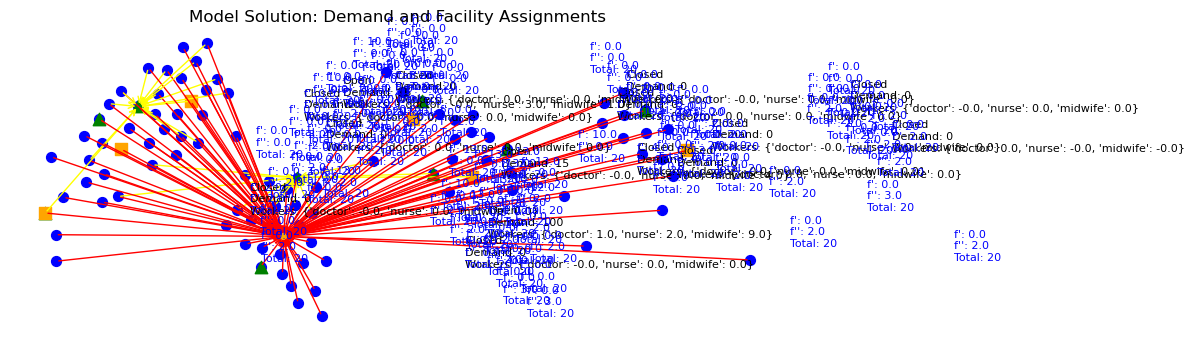

In [6]:
# Plot the solution

plot_solution(model, demand_points_gdf, hfs_gdf)


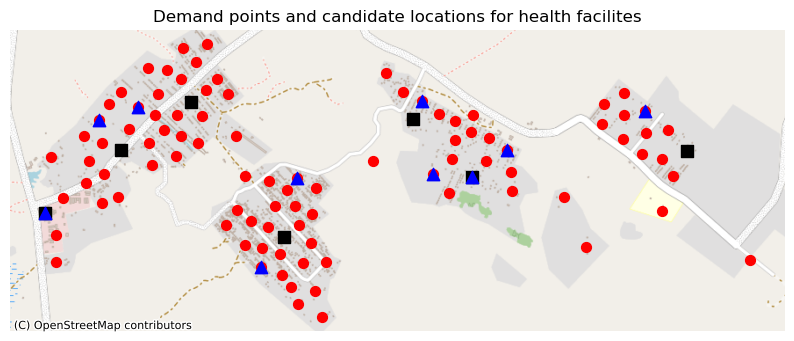

In [7]:
# Plot the solution with a map background (only if our demand points and facilities have real-world coordinates; otherwise, use the code in the above cell)

plot_solution_with_map(model, demand_points_gdf, hfs_gdf, show_arrows=False, show_HF_text=False)


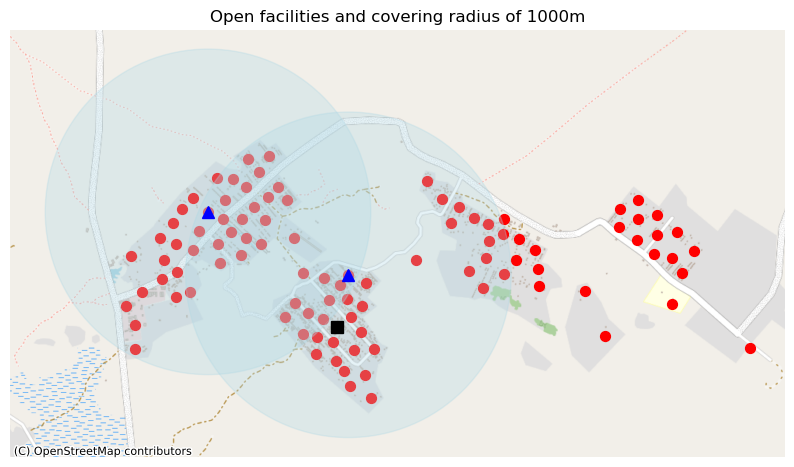

In [8]:
# Plot the solution with a map background and a circle of radius t1max around HPs

plot_solution_with_covering_radius(model, demand_points_gdf, hfs_gdf, cov_radius = model.t1_max.value)  # Adjust t1max as necessary


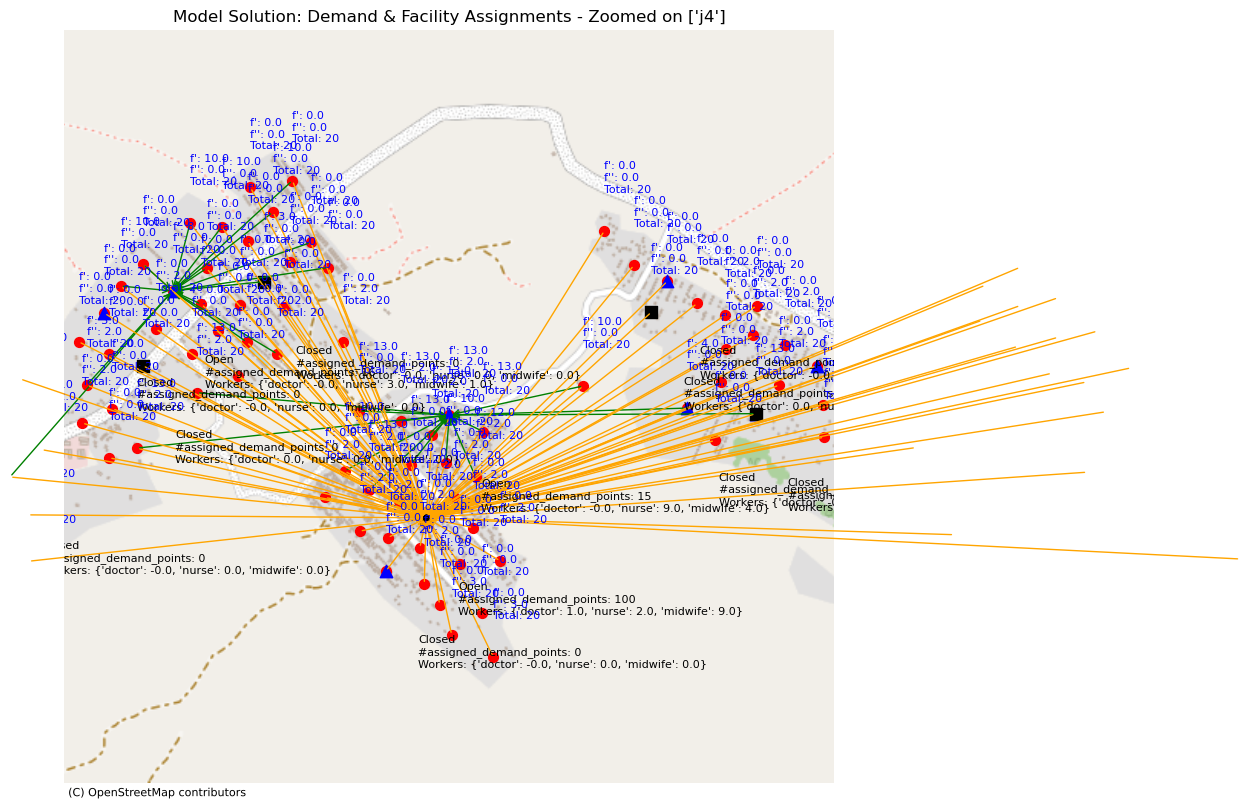

In [9]:
# Plot the solution with a map background and zoom in around a specified open facility

plot_solution_with_map_zoom(model, demand_points_gdf, hfs_gdf, buffer_size = 1000, open_facility_label=['j4'])


In [10]:
# Display only the selected variables

display_selected_variables(model)


Selected variables (y_jl = 1, x1_ij = 1, x2_ij = 1, f1_ijs > 0, f2_ijs > 0, w_jp > 0, taumax > 0, deltamax > 0):
y[j2,hc] = 1.0
y[j4,hp] = 1.0
y[j13,hp] = 1.0
x1[i21,j4] = 1.0
x1[i22,j4] = 1.0
x1[i23,j13] = 1.0
x1[i25,j4] = 1.0
x1[i26,j4] = 1.0
x1[i27,j4] = 1.0
x1[i30,j4] = 1.0
x1[i34,j4] = 1.0
x1[i35,j4] = 1.0
x1[i37,j4] = 1.0
x1[i38,j4] = 1.0
x1[i39,j4] = 1.0
x1[i41,j4] = 1.0
x1[i43,j4] = 1.0
x1[i45,j4] = 1.0
x1[i46,j4] = 1.0
x1[i47,j13] = 1.0
x1[i58,j13] = 1.0
x1[i63,j13] = 1.0
x1[i79,j13] = 1.0
x1[i82,j13] = 1.0
x1[i83,j13] = 1.0
x1[i85,j13] = 1.0
x1[i87,j13] = 1.0
x1[i88,j13] = 1.0
x1[i91,j13] = 1.0
x1[i93,j13] = 1.0
x1[i96,j13] = 1.0
x1[i97,j13] = 1.0
x1[i98,j13] = 1.0
x1[i100,j13] = 1.0
x2[i1,j2] = 1.0 Demand Location is in camp 
x2[i2,j2] = 1.0 Demand Location is in camp 
x2[i3,j2] = 1.0 Demand Location is in camp 
x2[i4,j2] = 1.0 Demand Location is in camp 
x2[i5,j2] = 1.0 Demand Location is in camp 
x2[i6,j2] = 1.0 Demand Location is in camp 
x2[i7,j2] = 1.0 Demand Location i

In [11]:
# Create Summary table

generate_facility_summary(model)

Summary table with uncovered percentage saved as 'facility_summary_with_uncovered_percentage.html'.


,Facility ID,Facility Type,#Assigned Demand Points,Satisfied Demand (f1; f2),Total Demand (d1; d2),Efficiency (%),Utilization (Service/Personnel),Max Distance,Demand - Basic (Capacity),Demand - Maternal1 (Capacity),Demand - Maternal2 (Capacity),Personnel - Doctor,Personnel - Nurse,Personnel - Midwife
0,j2,hc,100,0; 91,0; 600,15.2%,98.9%,2540.89,0; 0 (46),0; 88 (88),0; 3 (39),1,2,9
1,j4,hp,15,176; 0,210; 0,83.8%,100.0%,979.05,144; 0 (144),32; 0 (104),0; 0 (16),0,9,4
2,j13,hp,16,56; 0,224; 0,25.0%,100.0%,769.92,48; 0 (48),8; 0 (32),0; 0 (4),0,3,1
